# Stroke Predictors

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

import prepare
import model

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB

# Acquire and Prep

In [51]:
# acquire dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

> File originally downloaded from Kaggle.com. A copy is available in our germain-capstone-stoke-prediction repo. 

In [52]:
# prepare data using script
df = prepare.prep_data(df).drop(columns=['age_range'])

### Prep Process
> - Takes the original Kaggle dataset,
> - Drops a row for an outlier in gender and reset index, 
> - Drop the id column because the index serves the same,
> - Converts ordinal columns to objects for one-hot encoding,
> - Creates age_range feature for 5-year increments,
> - Imputes BMI nulls using average BMI for observation's age range and gender, and
> - Returns the prepared dataframe. This does not do model prep work.

In [53]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Explore plan
- Look at distributions
- Split
- Using Train answer hyptheses

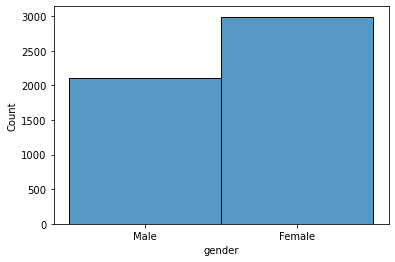

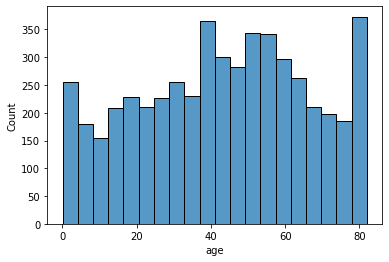

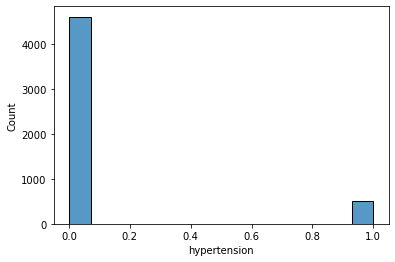

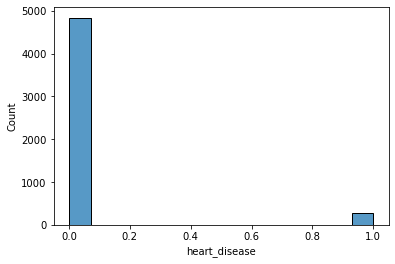

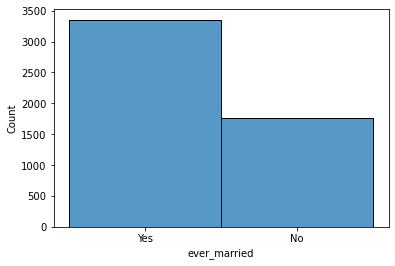

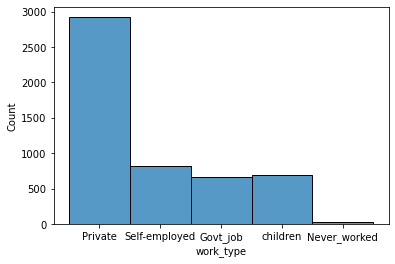

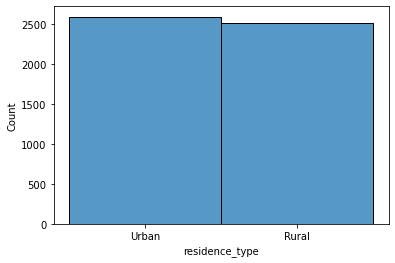

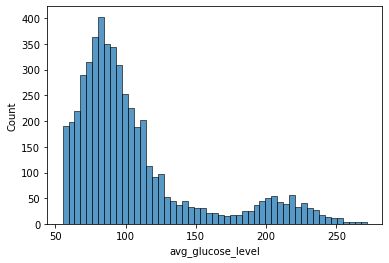

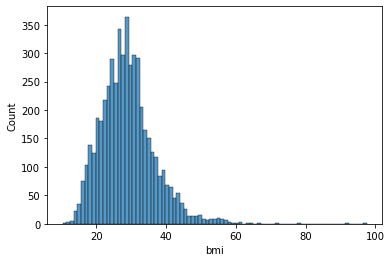

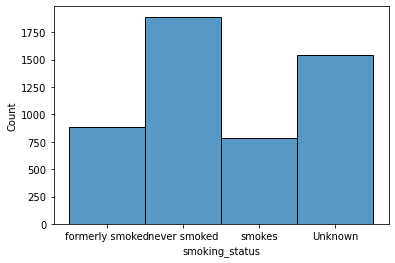

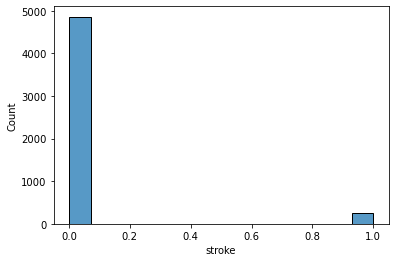

In [5]:
# creating the distribution plot for each column
for col in df.columns:
    sns.histplot(df[col])
    plt.show()

- age is left skewed
- average glucose level is right skewed
- bmi is close to normally distributed

# Splits

In [6]:
# split the dataset into train_validate and test
train_validate, test = train_test_split(df, test_size=.2, random_state=777)

In [7]:
# the second split of train and validate
train, validate = train_test_split(train_validate, test_size=.25, random_state=777)

In [8]:
# checking the shape of each dataset
train.shape, validate.shape, test.shape

((3065, 11), (1022, 11), (1022, 11))

# Hypothesis Testing

## Hypothesis 1: There is relationship between average glucose level and BMI.
> - $H_0$ : There is no relationship between average glucose level and BMI.
> - $H_A$ : There is relationship between average glucose level and BMI.
> - Confidence interval is 95%

In [9]:
alpha = .05

<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

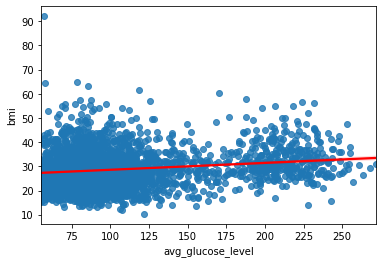

In [10]:
# creating a scatterplot to show the relationsip between avg glucose level and bmi
# hue= and bins= for colorization fanciness
sns.regplot(data=train, x="avg_glucose_level", y="bmi",line_kws={'color': 'red'})

In [11]:
# here we conduct a pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)
corr, p

(0.1715344761292883, 1.1366471558585545e-21)

In [12]:
# comparing the p-value to alpha
if p < alpha:
    print('There is a relationship between average glucose level and bmi.')
else:
    print('We can not say with 95% confidence that there is a realionship between average glucose level and bmi.')

There is a relationship between average glucose level and bmi.


### Result:
> #### We are 95% confident that there is a relationship between average glucose level and BMI.

## Hypothesis 2: People over 65 years old are more likely to have a stroke than people under 65.
> - $H_0$ : People over 65 years old are not more likely to have a stroke than people under 65.
> - $H_A$ : People over 65 years old are more likely to have a stroke than people under 65.
> - Confidence interval is 95%

In [13]:
alpha = .05

In [14]:
# creating samples based on age over or under 65
over_65 = train[train.age >= 65]
under_65 = train[train.age < 65]

In [15]:
t, p = stats.mannwhitneyu(over_65.stroke, under_65.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(849465.0, 2.6226245960247797e-39)

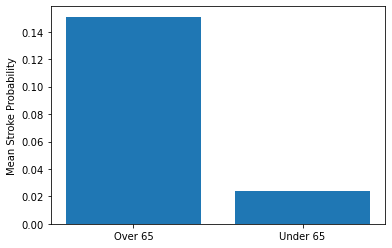

In [16]:
heights = [round(over_65.stroke.mean(), 3), round(under_65.stroke.mean(), 3)]
x_labels = ['Over 65', 'Under 65']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability")
plt.show()

In [17]:
# Comparing the p-value to alpha
if p < alpha and t > 0:
    print('People over 65 years old are more likely to have a stroke than people under 65')
else:
    print('We can not say with 95% confidence that people over 65 years old are not more likely to have a stroke than people under 65')

People over 65 years old are more likely to have a stroke than people under 65


### Result:
> #### We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.

## Hypothesis 3: People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - $H_0$ : People that currently smoke do not have a higher risk of stroke than people that don’t currently smoke.
> - $H_A$ : People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - Confidence interval is 95%

In [18]:
alpha = .05

In [19]:
train.smoking_status.value_counts()

never smoked       1124
Unknown             940
formerly smoked     517
smokes              484
Name: smoking_status, dtype: int64

In [20]:
active_smoker = train[train.smoking_status == "smokes"]
not_active_smoker = train[train.smoking_status != "smokes"]

t, p = stats.mannwhitneyu(active_smoker.stroke, not_active_smoker.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(637100.0, 0.031009877989108668)

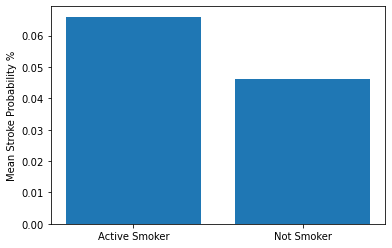

In [48]:
heights = [round(active_smoker.stroke.mean(), 3), round(not_active_smoker.stroke.mean(), 3)]
x_labels = ['Active Smoker', 'Not Smoker']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability %")
plt.show()

In [22]:
# comparing the p-value to alpha
if p < alpha and t>0:
    print('People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')
else:
    print('We can not say with 95% confidence that People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')

People that currently smoke have a higher risk of stroke than people that don’t currently smoke.


### Result:
> #### We are 95% confident that people that currently smoke have a higher risk of stroke than people that don’t currently smoke.


## Hypothesis 4: Men are more at risk for stroke than women.
> - $H_0$ : Men are not more at risk for stroke than women.
> - $H_A$ : Men are more at risk for stroke than women.
> - Confidence interval is 95%

In [23]:
alpha = .05

In [24]:
train.gender.value_counts()

Female    1806
Male      1259
Name: gender, dtype: int64

In [25]:
men = train[train.gender == "Male"]
women = train[train.gender != "Male"]

t, p = stats.mannwhitneyu(men.stroke, women.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(1141435.0, 0.30698159499864974)

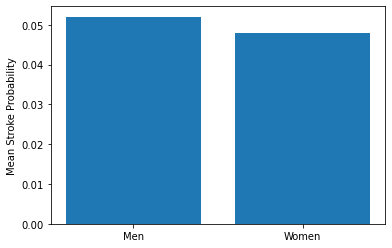

In [26]:
heights = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]
x_labels = ['Men', 'Women']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability")
plt.show()

In [27]:
# comparing the p-value to alpha
if p < alpha and t > 0:
    print('Men are more at risk for stroke than women.')
else:
    print('We can not say with 95% confidence that men are more at risk for stroke than women.')

We can not say with 95% confidence that men are more at risk for stroke than women.


### Result:
> #### We can not say with 95% confidence that men are more at risk for stroke than women.

# **Takeways**:
> - There is a relationship between average glucose level and bmi.
> - People over 65 years old are more likely to have a stroke than people under 65
> - People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - We can not say with 95% confidence that Men are more at risk for stroke than women.

In [28]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [29]:
# prepare data using script
df = prepare.prep_data(df).drop(columns=['age_range',])
df.stroke.dtype

dtype('int64')

In [30]:
# cast stroke column as int
df['stroke'] = df['stroke'].astype('int64')
# check work
df.shape

(5109, 11)

In [31]:
# check work
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [32]:
# set list of columns to one-hot encode
col_list = ['gender','ever_married','work_type','residence_type','smoking_status']
# apply one-hot encoding using above list
df = pd.get_dummies(df, columns=col_list, drop_first=True)

In [33]:
# split using same random state as explore stage
trainvalidate, test = train_test_split(df, test_size=.2, random_state=777)
train, validate = train_test_split(trainvalidate, test_size=.25, random_state=777)
# check work
train.shape, validate.shape, test.shape

((3065, 16), (1022, 16), (1022, 16))

In [34]:
# isolate target
X_train, y_train = train.drop(columns='stroke'), train.stroke
X_validate, y_validate = validate.drop(columns='stroke'), validate.stroke
X_test, y_test = test.drop(columns='stroke'), test.stroke

In [35]:
# apply scaling using a MinMaxScaler
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = model.Min_Max_Scaler(X_train, X_validate, X_test)

In [36]:
# build & fit models, append model predictions to the train and validate actuals dataframes
y_train_predictions,\
y_validate_predictions = model.classification_shotgun(X_train_scaled, y_train, X_validate_scaled, y_validate)

In [37]:
y_train_predictions,\
y_validate_predictions = model.manual_baseline(y_train_predictions, y_validate_predictions, 1)

In [57]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.reset_option("display.max_rows", "display.max_columns")
y_train_predictions

,in_actuals,baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,nb_vsmooth0.01,nb_vsmooth10,nb_vsmooth100,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,manual_baseline,nb_best_model
448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4128,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# calculate accuracy and recall for in- and out-sample predictions
running_df = model.print_classification_results(y_train_predictions, y_validate_predictions)

In [40]:
# display accuracies and recalls for each model, sorting for best out-sample recall
running_df.sort_values(by='OutSample_Recall', ascending=False)

,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
27,manual_baseline,0.049266,0.043053,1.000000,1.000000
12,nb_vsmooth1e-09,0.351387,0.354207,0.980132,1.000000
13,nb_vsmooth1e-08,0.377162,0.383562,0.980132,1.000000
14,nb_vsmooth1e-07,0.424144,0.428571,0.953642,0.931818
15,nb_vsmooth1e-06,0.497879,0.510763,0.920530,0.909091
16,nb_vsmooth1e-05,0.578467,0.588063,0.894040,0.886364
17,nb_vsmooth0.0001,0.688091,0.695695,0.807947,0.795455
18,nb_vsmooth0.001,0.769984,0.785714,0.695364,0.659091
19,nb_vsmooth0.01,0.825122,0.839530,0.569536,0.545455
5,tree_maxdepth10,0.979772,0.947162,0.602649,0.159091


# Test

In [44]:
# create naive bayes model
nb = GaussianNB(var_smoothing=0.00001).fit(X_train, y_train_predictions.in_actuals)
# make predictions in new column
y_train_predictions['nb_best_model'] = nb.predict(X_train)
y_test = pd.DataFrame(y_test).rename(columns={'stroke':'out_actuals'})
y_test['nb_best_model']= nb.predict(X_test)


In [46]:
model.print_classification_results(y_train_predictions[['in_actuals','nb_best_model']], y_test[['out_actuals','nb_best_model']])

,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
0,nb_best_model,0.854812,0.83953,0.490066,0.37037


# Model Takeaways:
- Our best model was Naive-Bayes with var_smoothing of 0.00001
- We outperformed the baseline in OutSample_Accuracy
- manual_baseline OutSample_Accuracy = 0.043053, outSample_recall = 1.00
- nb_best_model OutSample_Accuracy = 0.83953, OutSample_Recall = 0.37037



# Conclusion

### Findings: 
> - There is a relationship between average glucose level and bmi.
> - People over 65 years old are more likely to have a stroke than people under 65
> - People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - We can not say with 95% confidence that Men are more at risk for stroke than women.
> - Our best model was Naive-Bayes with var_smoothing of 0.00001


# Recommendations:
- People who fall into any of the above mentioned categories should be cognizant of their increased risk.
- We recommend getting checked regularly by your physician, especially if you are over the age of 65. 

# If we had more time...
- We would explore different combinations of features that could help predict stroke, and whether or not some are independant of others. 
